In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\lucad\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lucad\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
df = pd.read_csv('spam_ham_dataset.csv')
stopwords = set(stopwords.words('english'))

In [19]:
df.describe()

,id,label_num
count,5171.000000,5171.000000
mean,2585.000000,0.289886
std,1492.883452,0.453753
min,0.000000,0.000000
25%,1292.500000,0.000000
50%,2585.000000,0.000000
75%,3877.500000,1.000000
max,5170.000000,1.000000


In [20]:
df.head()

,id,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


First, preprocess text to relevants tokens

In [21]:
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalpha() and word not in stopwords]
    return ' '.join(tokens)

In [22]:
df['text'] = df['text'].apply(preprocess_text)

In [ ]:
# Result
df.head()

,id,label,text,label_num
0,605,ham,subject enron methanol meter follow note gave ...,0
1,2349,ham,subject hpl nom january see attached file hpln...,0
2,3624,ham,subject neon retreat ho ho ho around wonderful...,0
3,4685,spam,subject photoshop windows office cheap main tr...,1
4,2030,ham,subject indian springs deal book teco pvr reve...,0


<Axes: title={'center': 'Spam vs Ham'}, xlabel='label'>

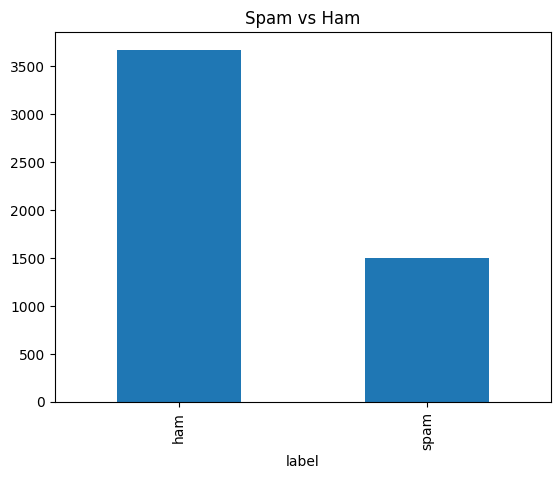

In [ ]:
df.groupby('label').size()
df['label'].value_counts().plot(kind='bar', title='Spam vs Ham')

Theres desbalanced data, so it's needed to use a strategy to correct it, in this case I'm going to use SMOTE

In [ ]:
# First get the samples to use

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['text'])

y = df[['label_num']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
smote = SMOTE(sampling_strategy='minority',k_neighbors=5)
X_sm, y_sm = smote.fit_resample(X_train,y_train)

In [30]:
X_smote = pd.DataFrame(data=X_sm,columns=['text'])
y_smote = pd.DataFrame(data=y_sm,columns=['label_num'])

df_train_smote = pd.concat([X_smote, y_smote],axis=1)
df_train_smote.count()

text         5860
label_num    5860
dtype: int64

SMOTE:
label_num
0    2930
1    2930
Name: count, dtype: int64


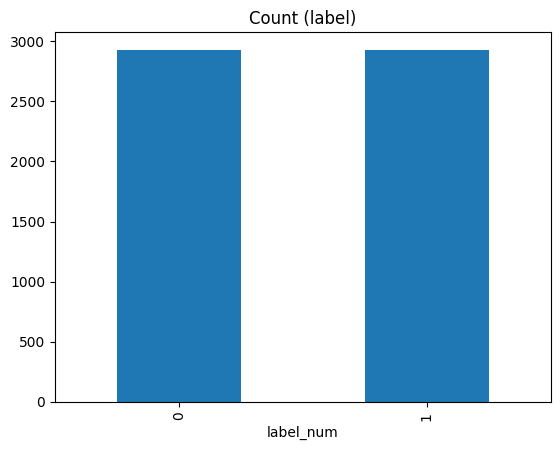

In [31]:
print('SMOTE:')
print(df_train_smote.label_num.value_counts())

df_train_smote.label_num.value_counts().plot(kind='bar', title='Count (label)');

In [32]:
model = MultinomialNB()
model.fit(X_sm, y_sm)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.98

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98       742
           1       0.96      0.97      0.96       293

    accuracy                           0.98      1035
   macro avg       0.97      0.97      0.97      1035
weighted avg       0.98      0.98      0.98      1035



d:\Code\PyProjects\spam_or_ham\sohenv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


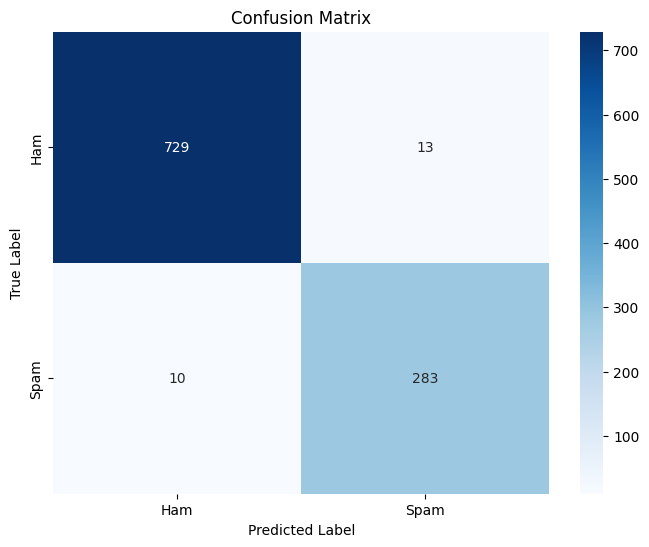

In [40]:
# Visualizing the results
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [39]:
def predict(text):
    text = preprocess_text(text)
    text_vectorized = vectorizer.transform([text])
    prediction = model.predict(text_vectorized)
    return prediction[0]

In [42]:
# Test the prediction function
texts = [
    "Congratulations! You've won a lottery of $1000!",
    "Hey, how are you doing today? Let's catch up later.",
    "This is a reminder for your appointment tomorrow.",
    "You've been selected for a free gift card! Click here to claim.",
]
for text in texts:
    prediction = predict(text)
    print(f"Text: '{text}' => Prediction: {'Spam' if prediction == 1 else 'Ham'}")

Text: 'Congratulations! You've won a lottery of $1000!' => Prediction: Spam
Text: 'Hey, how are you doing today? Let's catch up later.' => Prediction: Ham
Text: 'This is a reminder for your appointment tomorrow.' => Prediction: Ham
Text: 'You've been selected for a free gift card! Click here to claim.' => Prediction: Spam


In [43]:
# Save the model and vectorizer
import joblib
joblib.dump(model, 'spam_classifier_model.pkl')
joblib.dump(vectorizer, 'vectorizer.pkl')

['vectorizer.pkl']